In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from ast import literal_eval
import openslide
import cv2
import math

slide_path = '/fs/ess/PAS1575/Dataset/CAMELYON16/testing/images/'
slide_mask_path = '/fs/ess/PAS1575/Dataset/CAMELYON16/testing_masks/'

output_path = './gt_and_fixation_new/'

down_scale = 32 # default value that needs to be adjusted

# get slide tissue threshold from a set of files
df_thresholds = pd.DataFrame()
for i in range(1,11):
    df_thresholds = pd.concat([pd.read_csv(f'../non_overlap_tiles/test_slides_tissue_thresholds_{i}_of_10.csv'), df_thresholds], ignore_index=True)

In [2]:
# load in eye fixation data
pids = ['P1','P3','P4','P5','P6','P7','P8','P10']

df_image = pd.read_csv('images.csv')

df_eyetrack = pd.read_csv('./TrackerData/Exp1_CombinedGazeMouseData.csv')
df_eyetrack = df_eyetrack[df_eyetrack['participantID'].isin(pids)]

eyetrack_images = df_eyetrack['imageID'].dropna().unique()
print(f"{len(eyetrack_images)} unique images in eye tracking data")

60 unique images in eye tracking data


In [3]:
# Convert to DataFrame for merging
df_test_reference = pd.read_csv('../cam16_test_reference.csv')

df_combined = pd.merge(df_image, df_test_reference, left_on='image_name', right_on='image_id')
df_combined = df_combined[~df_combined['image_id_x'].str.contains('TC')]
df_combined = df_combined[['image_id_x', 'image_name', 'type', 'level']]
df_combined.columns = ['img_id', 'image_name', 'type', 'level']

# get participantID and imageID pairs from df_eyetrack
df_eyetrack_pairs = df_eyetrack[['participantID', 'imageID']].dropna().drop_duplicates()
df_eyetrack_pairs.columns = ['pid', 'img_id']

# merge with df_combined to get levels
df_combined = pd.merge(df_combined, df_eyetrack_pairs, on='img_id')

# merge with df_combined to get correctness
df_pid_answers = pd.read_csv('../experimentData/allParticipantsAnswers.csv')
df_pid_answers = df_pid_answers[['pID', 'imageID', 'correctness']]
df_pid_answers.columns = ['pid', 'img_id', 'correctness']
df_combined = pd.merge(df_combined, df_pid_answers, on=['pid', 'img_id'])

# change none to Normal in level and delete type column
df_combined['level'] = df_combined['level'].replace('None', 'Normal')
df_combined = df_combined.drop(columns=['type'])

In [4]:
def parse_tissue_thresh(val):
    """Parse a tissue_thresh value into (minhsv, maxhsv).
    Handles formats like:
      - numpy repr: "array([55, 38, 70], dtype=uint8), array([180,200,210], dtype=uint8)"
      - Python literals: "([55,38,70], [180,200,210])" or "[ [..], [..] ]"
      - JSON arrays
      - plain numeric lists or space/comma separated numbers
    Returns a 2-tuple (minhsv, maxhsv).
    """
    import re
    from ast import literal_eval
    import json
    import pandas as _pd
    # Guard None/NaN
    if val is None or (_pd.isna(val) if isinstance(val, (str, float, int, list, tuple)) else False):
        raise ValueError('tissue_thresh is missing')
    s = str(val).strip()
    # Quick clean: convert common numpy reprs into a Python literal
    # 1) remove leading 'array(' tokens but keep bracket contents
    s_clean = re.sub(r"\barray\s*\(", "", s)
    # 2) remove dtype=... inside array(...), replace trailing ')' of array(...) with ']' when appropriate
    s_clean = re.sub(r",\s*dtype\s*=\s*[^\)\]]+\)", "]", s_clean)
    # 3) drop any stray closing parens left from array(...) replacements
    s_clean = s_clean.replace(')', '')
    # 4) ensure that multiple bracketed groups become a tuple for literal_eval
    #    e.g. "[...], [...]" -> "([...],[...])"
    if re.search(r"\]\s*,\s*\[", s_clean) and not s_clean.strip().startswith('('):
        s_clean = '(' + s_clean + ')'
    # 5) attempt literal_eval on the cleaned string
    try:
        parsed = literal_eval(s_clean)
        # If parsed is a single list of two lists: [[...],[...]]
        if isinstance(parsed, (list, tuple)) and len(parsed) == 2:
            return parsed[0], parsed[1]
        # If parsed is a flat list of 6 numbers -> split into two 3-tuples
        if isinstance(parsed, (list, tuple)) and len(parsed) == 6:
            return tuple(parsed[:3]), tuple(parsed[3:6])
    except Exception:
        pass
    # 6) try JSON as fallback
    try:
        parsed = json.loads(s)
        if isinstance(parsed, (list, tuple)) and len(parsed) == 2:
            return parsed[0], parsed[1]
    except Exception:
        pass
    # 7) final fallback: extract numeric tokens
    nums = re.findall(r"[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?", s_clean)
    if len(nums) >= 6:
        nums = [float(x) for x in nums]
        return tuple(nums[:3]), tuple(nums[3:6])
    if len(nums) >= 2:
        nums = [float(x) for x in nums]
        return nums[0], nums[1]
    raise ValueError(f"Cannot parse tissue_thresh value: {s}")

In [5]:
def get_thumbnail_white_bg(slide_name, gt_color=(255,0,0), pad_pixels=20):
    """Return a thumbnail with white background and contours drawn for the given slide_name.
    Uses globals: slide_path, slide_mask_path, df_thresholds, down_scale.
    Returns: (thumbnail_np, thumbnail_white_bg, tissue_bbox)
      tissue_bbox: [xmin, ymin, xmax, ymax] in thumbnail pixel coordinates (with padding).
    """
    # Build paths from global variables
    imgPath = slide_path + slide_name + '.tif'
    imgPathMask = slide_mask_path + slide_name + '_mask.tif'

    # Read mask thumbnail (used for sizing) and the original thumbnail
    with openslide.open_slide(imgPathMask) as mask_slide:
        nx, ny = mask_slide.dimensions
        thumb_mask = mask_slide.get_thumbnail((nx/down_scale, ny/down_scale))
        thumb_mask_grey = np.array(thumb_mask.convert('L'))
    with openslide.open_slide(imgPath) as slide:
        thumbnail = slide.get_thumbnail((nx/down_scale, ny/down_scale))

    thumbnail_np = np.array(thumbnail)

    # Get thresholds for this slide from the global df_thresholds
    record_thresholds = df_thresholds[df_thresholds['slide_name'] == slide_name]
    if record_thresholds.shape[0] == 0:
        raise ValueError(f'No threshold record for slide: {slide_name}')
    record = record_thresholds.iloc[0]
    minhsv, maxhsv = parse_tissue_thresh(record['tissue_thresh'])

    # Convert to HSV and create mask (tissue mask)
    thumbnail_hsv = cv2.cvtColor(thumbnail_np, cv2.COLOR_RGB2HSV)
    dtype = thumbnail_hsv.dtype
    lower = np.array(minhsv, dtype=dtype)
    upper = np.array(maxhsv, dtype=dtype)
    mask = cv2.inRange(thumbnail_hsv, lower, upper)
    mask_inv = cv2.bitwise_not(mask)

    # Create a white-background thumbnail where background (mask_inv>0) is white
    thumbnail_masked = thumbnail_np.copy()
    thumbnail_masked[mask_inv > 0] = [255, 255, 255]
    thumbnail_white_bg = thumbnail_masked.copy()

    # Create a binary mask (0/1) from the mask (which is 0/255)
    mask_binary = (mask > 0).astype(np.uint8)
    
    # Clean up the mask for bounding box calculation
    kernel = np.ones((5,5), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask_binary, cv2.MORPH_OPEN, kernel)  # Remove small noise
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)  # Fill small holes
    
    # Find contours for statistics
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Process ground truth mask and draw its contours
    gt_mask = (thumb_mask_grey > 0).astype(np.uint8)
    gt_contours, _ = cv2.findContours(gt_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw ground truth contours in red on the white background image
    cv2.drawContours(thumbnail_white_bg, gt_contours, -1, gt_color, 3)
    
    # Compute bounding box from the cleaned mask
    h, w = mask_binary.shape[:2]
    ys, xs = np.where(mask_cleaned > 0)
    if xs.size == 0 or ys.size == 0:
        print(f"Warning: No tissue detected in {slide_name}. Check HSV thresholds.")
        print(f"HSV thresholds used: min={minhsv}, max={maxhsv}")
        xmin, ymin, xmax, ymax = 0, 0, w - 1, h - 1
    else:
        # Find the bounding box that contains all tissue regions
        xmin = int(xs.min())
        xmax = int(xs.max())
        ymin = int(ys.min())
        ymax = int(ys.max())
        
        # Add padding but don't exceed image bounds
        xmin = max(0, xmin - pad_pixels)
        ymin = max(0, ymin - pad_pixels)
        xmax = min(w - 1, xmax + pad_pixels)
        ymax = min(h - 1, ymax + pad_pixels)
    
    # Debug information
    total_area = w * h
    tissue_area = mask_cleaned.sum()
    print(f"Image size: {w}x{h}")
    print(f"Number of tissue regions: {len(contours)}")
    print(f"Total tissue area: {tissue_area} pixels ({(tissue_area/total_area)*100:.1f}% of image)")
    print(f"Number of ground truth regions: {len(gt_contours)}")

    tissue_bbox = [xmin, ymin, xmax, ymax]
    return thumbnail_np, thumbnail_white_bg, tissue_bbox

In [6]:
# check data
pid = 'P1'
img_id = 'C7'
df_fix = df_eyetrack[(df_eyetrack['participantID'] == pid) 
                     & (df_eyetrack['imageID'] == img_id)
                     & (df_eyetrack['EyeMovementType']=='Fixation') # Saccade, Fixation
                     # & (df_eyetrack['inMenu'] == True) # filter out very short fixations
                    ]  
df_fix = df_fix.sort_values('relativeTimestamp(ms)').copy()
df_fix = df_fix[['imageID',	'participantID', 'EyeMovementType', 'ImageFixationPointX(px)', 'ImageFixationPointY(px)', 'inMenu', 'inNavigator','zoomMagnification']]
# df_fix.tail(20)
df_fix['inNavigator'] = df_fix['inNavigator'].fillna(False)
df_fix[df_fix['inNavigator']==True]

# show rows between 15542 and 15578
# df_fix[(df_fix.index >= 15542) & (df_fix.index <= 15578)]

df_fix.head(10)

,imageID,participantID,EyeMovementType,ImageFixationPointX(px),ImageFixationPointY(px),inMenu,inNavigator,zoomMagnification
15539,C7,P1,Fixation,57930.107107,102165.918139,False,False,1.00
15540,C7,P1,Fixation,57474.605908,100192.430864,False,False,1.00
15542,C7,P1,Fixation,NaN,NaN,False,True,1.00
15544,C7,P1,Fixation,NaN,NaN,True,False,1.00
15568,C7,P1,Fixation,66280.962416,105809.279261,False,False,1.00
15578,C7,P1,Fixation,NaN,NaN,False,True,1.00
15592,C7,P1,Fixation,20882.676281,101862.304712,False,False,1.00
15600,C7,P1,Fixation,18605.170288,93512.935473,False,False,1.00
15611,C7,P1,Fixation,44611.565878,98891.876450,False,False,2.25
15624,C7,P1,Fixation,29565.442899,96598.256963,False,False,2.25


In [7]:
def get_fixations_for_slide(pid, img_id, df_eyetrack, down_scale=32):
    """Filter and clean fixations for a given participant and image, then return scaled X, Y and sizes.

    This version computes df_fix internally and returns only (X, Y, sizes).
    Coordinates are scaled by `down_scale` to match thumbnails.
    """
    # Select relevant fixations and sort
    df_fix = df_eyetrack[(df_eyetrack['participantID'] == pid) &
                         (df_eyetrack['imageID'] == img_id) &
                         (df_eyetrack['EyeMovementType']=='Fixation')]
    
    # remove data whose X are nan
    df_fix = df_fix[pd.notna(df_fix['ImageFixationPointX(px)']) & pd.notna(df_fix['ImageFixationPointY(px)'])]

    # sort by time
    df_fix = df_fix.sort_values('relativeTimestamp(ms)').copy()

    # Ensure column exists and coerce to numeric
    df_fix['GazeEventDuration(ms)'] = pd.to_numeric(df_fix.get('GazeEventDuration(ms)', pd.Series(dtype=float)), errors='coerce')

    # Replace remaining NaN or negative durations with zero
    df_fix['GazeEventDuration(ms)'] = df_fix['GazeEventDuration(ms)'].fillna(0).clip(lower=0)

    # Compute scaled coordinates and sizes
    X = (df_fix['ImageFixationPointX(px)'] / down_scale).astype(float).tolist()
    Y = (df_fix['ImageFixationPointY(px)'] / down_scale).astype(float).tolist()
    sizes = df_fix['GazeEventDuration(ms)'].astype(float).tolist()

    return X, Y, sizes


def get_mouse_for_slide(pid, img_id, df_eyetrack, down_scale=32):
    """Filter and clean mouse actions for a given participant and image, then return scaled X, Y.

    This version computes df_fix internally and returns only (X, Y).
    Coordinates are scaled by `down_scale` to match thumbnails.
    """
    # Select relevant fixations and sort
    df_fix = df_eyetrack[(df_eyetrack['participantID'] == pid) &
                         (df_eyetrack['imageID'] == img_id)]

    # remove data whose X are nan
    df_fix = df_fix[pd.notna(df_fix['ImageMousePositionX(px)']) & pd.notna(df_fix['ImageMousePositionY(px)'])]

    # sort by time
    df_fix = df_fix.sort_values('relativeTimestamp(ms)').copy()

    # Ensure column exists and coerce to numeric
    df_fix['GazeEventDuration(ms)'] = pd.to_numeric(df_fix.get('GazeEventDuration(ms)', pd.Series(dtype=float)), errors='coerce')

    # Replace remaining NaN or negative durations with zero
    df_fix['GazeEventDuration(ms)'] = df_fix['GazeEventDuration(ms)'].fillna(0).clip(lower=0)

    # Compute scaled coordinates and sizes
    X = (df_fix['ImageMousePositionX(px)'] / down_scale).astype(float).tolist()
    Y = (df_fix['ImageMousePositionY(px)'] / down_scale).astype(float).tolist()

    return X, Y

In [8]:
# Menu jump detection and marker definitions
XCOL = 'ImageFixationPointX(px)'
YCOL = 'ImageFixationPointY(px)'
IMCOL = 'inMenu'

def get_menu_jump_indices(df, require_return_fixation=False):
    """
    Mark index i if:
      - row i is a valid fixation (not in menu, finite XY)
      - and there is at least one inMenu=True row between row i and the next valid fixation.
        If require_return_fixation=True, only mark when a *next* fixation exists.
        If False, also mark the last fixation if the sequence ends with a menu run.
    Returns a list of integer row indices (relative to df) to annotate.
    """
    d = df.copy()

    # 1) Coerce inMenu to pure booleans
    if IMCOL not in d.columns:
        d[IMCOL] = False
    d[IMCOL] = d[IMCOL].fillna(False).astype(bool)

    # 2) Valid fixation rows (not menu + finite XY)
    x = d[XCOL].to_numpy()
    y = d[YCOL].to_numpy()
    in_menu = d[IMCOL].to_numpy()

    finite_xy = np.isfinite(x) & np.isfinite(y)
    valid = (~in_menu) & finite_xy
    valid_idx = np.flatnonzero(valid)

    if valid_idx.size == 0:
        return []

    marks = []
    n = len(d)

    # 3) For each fixation i, scan the slice until the next fixation
    for k, i in enumerate(valid_idx):
        j_next = valid_idx[k+1] if (k+1) < valid_idx.size else n  # end if last fixation
        if i+1 >= j_next:  # no rows between i and next fixation
            continue

        # any menu rows in (i, j_next)?
        if in_menu[i+1:j_next].any():
            # Optionally require a return fixation
            if require_return_fixation and j_next == n:
                # sequence ended after a menu run — skip marking if you don't want trailing-menu marks
                continue
            marks.append(int(i))

    return marks


from matplotlib.path import Path
import matplotlib.markers as mmarkers

def make_hamburger_marker():
    """
    Create a hamburger (menu) marker: three horizontal bars as a single Path.
    Coordinates are in roughly [-0.5, 0.5] box so 's' in scatter scales nicely.
    """
    bars = [
        (-0.5,  0.35), (0.5,  0.35), (0.5,  0.50), (-0.5,  0.50), (-0.5,  0.35),  # top bar
        (-0.5, -0.075), (0.5, -0.075), (0.5,  0.075), (-0.5,  0.075), (-0.5, -0.075),  # middle bar
        (-0.5, -0.50), (0.5, -0.50), (0.5, -0.35), (-0.5, -0.35), (-0.5, -0.50)   # bottom bar
    ]
    # Build codes: MOVETO + 3 LINETOs + CLOSEPOLY for each rectangle (5 verts per bar)
    codes = []
    verts = []
    for bi in range(3):
        i0 = bi * 5
        verts.extend(bars[i0:i0+5])
        codes.extend([Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY])
    path = Path(verts, codes)
    return mmarkers.MarkerStyle(path)

def get_valid_fixations_xy(df, down_scale=1.0):
    """Return (X, Y, durations_array or None) for all non-menu rows with finite XY."""
    xcol, ycol = 'ImageFixationPointX(px)', 'ImageFixationPointY(px)'

    # Normalize inMenu column to pure booleans (True/False)
    if 'inMenu' in df.columns:
        df = df.copy()
        df['inMenu'] = df['inMenu'].fillna(False).astype(bool)
    else:
        df['inMenu'] = False

    # Valid fixation points (not in menu and finite XY)
    m = (~df['inMenu']) & np.isfinite(df[xcol]) & np.isfinite(df[ycol])

    X = (df.loc[m, xcol].values) / down_scale
    Y = (df.loc[m, ycol].values) / down_scale

    # Optional duration column
    if 'FixationDuration(ms)' in df.columns:
        size = df.loc[m, 'FixationDuration(ms)'].astype(float).fillna(0).values
    else:
        size = np.ones_like(X, dtype=float)
        
    return X, Y, size

In [9]:
# Navigation jump detection
def get_navigator_jump_indices(df):
    """Return fixation row indices followed by inNavigator=True rows."""
    d = df.copy()
    if 'inNavigator' not in d.columns:
        return []
    d['inNavigator'] = d['inNavigator'].fillna(False).astype(bool)

    xcol, ycol = 'ImageFixationPointX(px)', 'ImageFixationPointY(px)'
    x = d[xcol].to_numpy()
    y = d[ycol].to_numpy()
    nav = d['inNavigator'].to_numpy()
    finite_xy = np.isfinite(x) & np.isfinite(y)
    valid = (~nav) & finite_xy
    valid_idx = np.flatnonzero(valid)

    marks = []
    n = len(d)
    for k, i in enumerate(valid_idx):
        j_next = valid_idx[k+1] if (k+1) < valid_idx.size else n
        if i+1 >= j_next:
            continue
        if nav[i+1:j_next].any():
            marks.append(int(i))
    return marks


In [10]:
# set participant and image
pid = 'P1'
img_id = 'C1'  # You can change this to test different images

In [12]:
# Test tissue detection
slide_name = df_image.at[df_image.index[df_image['image_id']==img_id].values[0], 'image_name']
print(f"Processing slide: {slide_name}")

# Get thumbnail with white background and ground truth contours
thumbnail_np, thumbnail_white_bg, tissue_bbox = get_thumbnail_white_bg(slide_name, gt_color=(255,0,0), pad_pixels=100)
xmin, ymin, xmax, ymax = tissue_bbox

# # Create figure with subplots
# fig, axes = plt.subplots(figsize=(8, 8))

# axes.imshow(thumbnail_white_bg)

# # set tissue bounding box using xlim and ylim to show the relevant area
# axes.set_xlim([xmin, xmax])
# axes.set_ylim([ymax, ymin])  # Note: y-axis inverted

# # Add legend for ground truth
# from matplotlib.patches import Patch
# legend_elements = [
#     Patch(facecolor='none', edgecolor='red', label='Ground Truth')
# ]
# axes.legend(handles=legend_elements, loc='upper left')

Processing slide: test_001
Image size: 2688x2800
Number of tissue regions: 674
Total tissue area: 95464 pixels (1.3% of image)
Number of ground truth regions: 29


Menu jump anchor fixations at rows: [88, 278, 401, 417]
Navigator jump anchor fixations at rows: [88, 278]


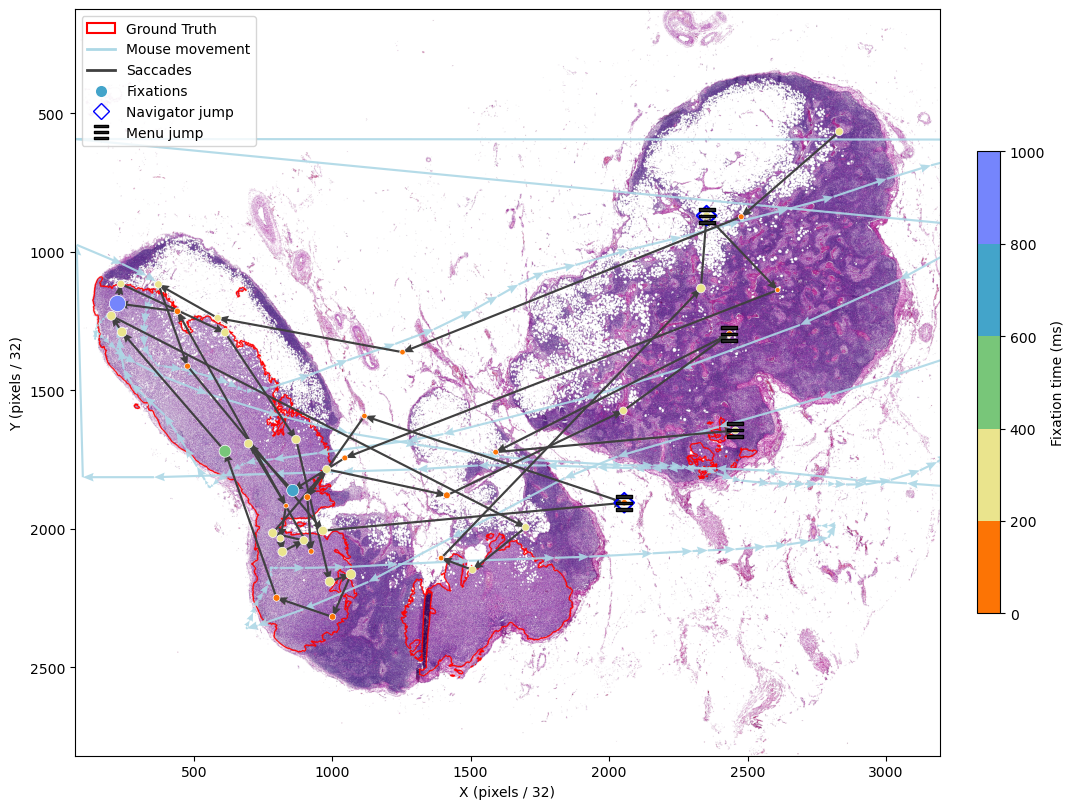

In [ ]:
# Filter to this participant+image
df_eye = df_eyetrack[(df_eyetrack["imageID"] == img_id)
                     & (df_eyetrack["participantID"] == pid)].copy()
df_eye = df_eye.sort_values('relativeTimestamp(ms)').copy()
df_eye['inMenu'] = df_eye['inMenu'].fillna(False).astype(bool)

# Compute menu-jump anchors (indices in df_eye)
menu_mark_indices = get_menu_jump_indices(df_eye)
print(f"Menu jump anchor fixations at rows: {menu_mark_indices}")

# Compute navigator jump anchors
nav_mark_indices = get_navigator_jump_indices(df_eye)
print(f"Navigator jump anchor fixations at rows: {nav_mark_indices}")

# Prepare plotting
fig, axs = plt.subplots(figsize=(12, 12))
axs.imshow(thumbnail_white_bg)

# plot mouse movements
X, Y = get_mouse_for_slide(pid, img_id, df_eye, down_scale=down_scale)

# Calculate the differences between consecutive points for arrow directions
dx = np.diff(X)
dy = np.diff(Y)
# Starting points of arrows (all points except the last)
X_start = X[:-1]
Y_start = Y[:-1]
# Plot arrows
axs.quiver(X_start, Y_start, dx, dy, scale_units='xy', angles='xy', scale=1, 
          color='lightblue', width=0.0025, headwidth=4, headlength=5, headaxislength=4.5,
          alpha=0.9, label='Mouse Movement')


# Get scaled fixation coordinates and sizes using helper (df_fix is handled inside the helper)
X, Y, size = get_fixations_for_slide(pid, img_id, df_eye, down_scale=down_scale)

# Create arrows between consecutive points
# Calculate the differences between consecutive points for arrow directions
dx = np.diff(X)
dy = np.diff(Y)
# Starting points of arrows (all points except the last)
X_start = X[:-1]
Y_start = Y[:-1]
# Plot arrows with a medium gray color
axs.quiver(X_start, Y_start, dx, dy, scale_units='xy', angles='xy', scale=1, 
          color='#404040', width=0.0025, headwidth=4, headlength=5, headaxislength=4.5)

# Prepare sizes and colors for scatter
import matplotlib as mpl
sizes_np = np.array(size, dtype=float)
# default to small positive if empty
if sizes_np.size == 0:
    sizes_np = np.array([1.0])

# scale sizes for plotting (tweak divisor/min for visibility)
sizes_plot = np.clip(sizes_np/8, 10, 200)

# Create fixed duration bins (0-200, 200-400, ..., 800-1000)
bins = np.array([0, 200, 400, 600, 800, 1000])
n_bins = len(bins) - 1
bin_indices = np.clip(np.digitize(sizes_np, bins) - 1, 0, n_bins-1)  # Clip to handle durations > 1000ms

# Use colorblind-safe and print friendly colors from Color Brewer
colors = ["#FC7405", "#eae48d", '#78c679', "#43a4ca", "#7585FC"] # choice 14

discrete_cmap = mpl.colors.ListedColormap(colors[:n_bins])

sc = axs.scatter(X, Y, s=sizes_plot, c=bin_indices, 
                cmap=discrete_cmap, alpha=1, 
                edgecolors='white', linewidths=0.5, zorder=3)

# Add colorbar showing gaze duration values
cbar = plt.colorbar(sc, ax=axs, fraction=0.03, pad=0.04,
                    shrink=0.5,
                   boundaries=np.arange(n_bins + 1),
                   values=np.arange(n_bins))
# Label with all duration values including 1000
cbar.set_ticks(np.arange(n_bins + 1))
duration_labels = [str(int(val)) for val in bins]
cbar.ax.set_yticklabels(duration_labels)
cbar.set_label('Fixation time (ms)')


# Use a clean black diamond or square
navigator_marker = 'D'   # diamond; you can switch to 's' (square) or '^' (triangle)
for ridx in nav_mark_indices:
    fx = df_eye.iloc[ridx][XCOL] / down_scale
    fy = df_eye.iloc[ridx][YCOL] / down_scale
    axs.scatter([fx], [fy],
                s=100, marker=navigator_marker,
                facecolor='none', edgecolor='blue', linewidth=1.5,
                zorder=9,
                label='Navigator jump' if ridx == nav_mark_indices[0] else "")


# Menu-jump hamburger markers at the *anchor fixation* positions
hamburger_marker = make_hamburger_marker()
for ridx in menu_mark_indices:                    # ridx is positional
    fx = df_eye.iloc[ridx][XCOL] / down_scale
    fy = df_eye.iloc[ridx][YCOL] / down_scale
    axs.scatter([fx], [fy],
                s=120, marker=hamburger_marker,   # bigger so it’s visible
                facecolor="#2D2D2DFF", edgecolor='black', linewidth=1,
                zorder=10, label='Menu jump' if ridx == menu_mark_indices[0] else "")


# set tissue bounding box using xlim and ylim
axs.set_xlim([xmin, xmax])
axs.set_ylim([ymax, ymin])  # Note: y-axis

# Add axis labels
axs.set_xlabel('X (pixels / 32)')
axs.set_ylabel('Y (pixels / 32)')

# Add legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='none', edgecolor='red', lw=1.5, label='Ground Truth'),
    Line2D([0], [0], color='lightblue', lw=2, label='Mouse movement'),
    Line2D([0], [0], color='#404040', lw=2, label='Saccade'),
    Line2D([0], [0], marker='o', color='w', label='Fixations',
           markerfacecolor='#43a4ca', markersize=9, markeredgecolor='white'),
    Line2D([0], [0], marker='D', color='w', label='Navigator jump',
           markerfacecolor='none', markeredgecolor='blue', markersize=8, lw=2),
    Line2D([0], [0], marker=make_hamburger_marker(), color='w', label='Menu jump',
           markerfacecolor='#2D2D2DFF', markeredgecolor='black', markersize=10)
]

axs.legend(handles=legend_elements, loc='best', frameon=True)
# axs.axis('off')

# save figure
fig.savefig(os.path.join(output_path, f'{pid}{img_id}_{slide_name}_fixations.png'), dpi=300, bbox_inches='tight')

Skipping existing file: P1C1_test_001_Macro_Correct.png
Skipping existing file: P3C1_test_001_Macro_Correct.png
Skipping existing file: P4C1_test_001_Macro_Correct.png
Skipping existing file: P5C1_test_001_Macro_Correct.png
Skipping existing file: P7C1_test_001_Macro_Correct.png
Skipping existing file: P8C1_test_001_Macro_Correct.png
Skipping existing file: P10C1_test_001_Macro_Correct.png
Skipping existing file: P1C2_test_008_Micro_Incorrect.png
Skipping existing file: P3C2_test_008_Micro_Correct.png
Skipping existing file: P4C2_test_008_Micro_Incorrect.png
Skipping existing file: P5C2_test_008_Micro_Incorrect.png
Skipping existing file: P7C2_test_008_Micro_Incorrect.png
Skipping existing file: P8C2_test_008_Micro_Incorrect.png
Skipping existing file: P10C2_test_008_Micro_Incorrect.png
Skipping existing file: P1C3_test_010_Micro_Incorrect.png
Skipping existing file: P3C3_test_010_Micro_Correct.png
Skipping existing file: P4C3_test_010_Micro_Correct.png
Skipping existing file: P5C3_tes

Image size: 3056x6832
Number of tissue regions: 1208
Total tissue area: 1805884 pixels (8.6% of image)
Number of ground truth regions: 0
Menu jump anchor fixations at rows: []
Navigator jump anchor fixations at rows: []


ValueError: 'c' argument has 1 elements, which is inconsistent with 'x' and 'y' with size 0.

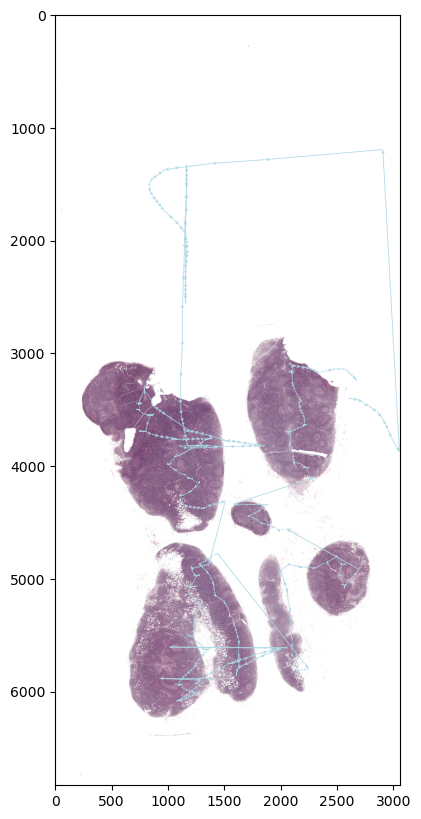

In [ ]:
### plot all images in df_combined

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib as mpl

cnt = 0
for idx, row in df_combined.iterrows():
    pid = row['pid']
    img_id = row['img_id']
    slide_name = row['image_name']
    correctness = row['correctness']
    level = row['level']

    if pid == 'P4' and img_id == 'C12':
        continue

    save_name = f'{pid}{img_id}_{slide_name}_{level}_{"Correct" if correctness else "Incorrect"}.png'
    if os.path.exists(os.path.join(output_path, save_name)):
        # print(f"Skipping existing file: {save_name}")
        continue

    print(f"Processing {pid} {img_id} ({slide_name}), level: {level}, correctness: {correctness}")
    
    # Get thumbnail with white background and ground truth contours
    thumbnail_np, thumbnail_white_bg, tissue_bbox = get_thumbnail_white_bg(slide_name, gt_color=(255,0,0), pad_pixels=100)
    xmin, ymin, xmax, ymax = tissue_bbox

    # Create figure with subplots
    fig, axs = plt.subplots(figsize=(10, 10))

    axs.imshow(thumbnail_white_bg)

    # ----------------------------------------------

    ### Filter to this participant+image
    df_eye = df_eyetrack[(df_eyetrack["imageID"] == img_id)
                        & (df_eyetrack["participantID"] == pid)].copy()
    df_eye = df_eye.sort_values('relativeTimestamp(ms)').copy()
    df_eye['inMenu'] = df_eye['inMenu'].fillna(False).astype(bool)

    # Compute menu-jump anchors (indices in df_eye)
    menu_mark_indices = get_menu_jump_indices(df_eye)
    print(f"Menu jump anchor fixations at rows: {menu_mark_indices}")

    # Compute navigator jump anchors
    nav_mark_indices = get_navigator_jump_indices(df_eye)
    print(f"Navigator jump anchor fixations at rows: {nav_mark_indices}")


    ### plot mouse movements
    X, Y = get_mouse_for_slide(pid, img_id, df_eye, down_scale=down_scale)

    # Calculate the differences between consecutive points for arrow directions
    dx = np.diff(X)
    dy = np.diff(Y)
    # Starting points of arrows (all points except the last)
    X_start = X[:-1]
    Y_start = Y[:-1]
    # Plot arrows
    axs.quiver(X_start, Y_start, dx, dy, scale_units='xy', angles='xy', scale=1, 
            color='lightblue', width=0.0025, headwidth=4, headlength=5, headaxislength=4.5,
            alpha=0.9, label='Mouse Movement')

    ### Plot saccades
    X, Y, size = get_fixations_for_slide(pid, img_id, df_eye, down_scale=down_scale)

    # Create arrows between consecutive points
    dx = np.diff(X)
    dy = np.diff(Y)
    # Starting points of arrows (all points except the last)
    X_start = X[:-1]
    Y_start = Y[:-1]
    # Plot arrows with a medium gray color
    axs.quiver(X_start, Y_start, dx, dy, scale_units='xy', angles='xy', scale=1, 
            color='#404040', width=0.0025, headwidth=4, headlength=5, headaxislength=4.5)

    ### Plot fixations with sizes/colors
    sizes_np = np.array(size, dtype=float)
    # default to small positive if empty
    if sizes_np.size == 0:
        sizes_np = np.array([1.0])

    # scale sizes for plotting (tweak divisor/min for visibility)
    sizes_plot = np.clip(sizes_np/8, 10, 200)

    # Create fixed duration bins (0-200, 200-400, ..., 800-1000)
    bins = np.array([0, 200, 400, 600, 800, 1000])
    n_bins = len(bins) - 1
    bin_indices = np.clip(np.digitize(sizes_np, bins) - 1, 0, n_bins-1)  # Clip to handle durations > 1000ms

    # Use colorblind-safe and print friendly colors from Color Brewer
    colors = ["#FC7405", "#eae48d", '#78c679', "#43a4ca", "#7585FC"] # choice 14

    discrete_cmap = mpl.colors.ListedColormap(colors[:n_bins])

    sc = axs.scatter(X, Y, s=sizes_plot, c=bin_indices, 
                    cmap=discrete_cmap, alpha=1, 
                    edgecolors='white', linewidths=0.5, zorder=3)

    ### Add colorbar showing gaze duration values
    cbar = plt.colorbar(sc, ax=axs, fraction=0.03, pad=0.04,
                        shrink=0.5,
                    boundaries=np.arange(n_bins + 1),
                    values=np.arange(n_bins))
    # Label with all duration values including 1000
    cbar.set_ticks(np.arange(n_bins + 1))
    duration_labels = [str(int(val)) for val in bins]
    cbar.ax.set_yticklabels(duration_labels)
    cbar.set_label('Fixation time (ms)')

    ### Navigation jump using a clean black diamond or square
    navigator_marker = 'D'   # diamond; you can switch to 's' (square) or '^' (triangle)
    if len(nav_mark_indices) > 0:
        for ridx in nav_mark_indices:
            fx = df_eye.iloc[ridx][XCOL] / down_scale
            fy = df_eye.iloc[ridx][YCOL] / down_scale
            axs.scatter([fx], [fy],
                        s=100, marker=navigator_marker,
                        facecolor='none', edgecolor='blue', linewidth=1.5,
                        zorder=9,
                        label='Navigator jump' if ridx == nav_mark_indices[0] else "")

    ### Menu-jump hamburger markers at the *anchor fixation* positions
    hamburger_marker = make_hamburger_marker()
    if len(menu_mark_indices) > 0:
        for ridx in menu_mark_indices:                    # ridx is positional
            fx = df_eye.iloc[ridx][XCOL] / down_scale
            fy = df_eye.iloc[ridx][YCOL] / down_scale
            axs.scatter([fx], [fy],
                        s=120, marker=hamburger_marker,   # bigger so it’s visible
                        facecolor="#2D2D2DFF", edgecolor='black', linewidth=1,
                        zorder=10, label='Menu jump' if ridx == menu_mark_indices[0] else "")

    ### Add legend
    legend_elements = [
        Patch(facecolor='none', edgecolor='red', lw=1.5, label='Ground Truth'),
        Line2D([0], [0], color='lightblue', lw=2, label='Mouse movement'),
        Line2D([0], [0], color='#404040', lw=2, label='Saccade'),
        Line2D([0], [0], marker='o', color='w', label='Fixations',
            markerfacecolor='#43a4ca', markersize=9, markeredgecolor='white'),
        Line2D([0], [0], marker='D', color='w', label='Navigator jump',
            markerfacecolor='none', markeredgecolor='blue', markersize=8, lw=2),
        Line2D([0], [0], marker=make_hamburger_marker(), color='w', label='Menu jump',
            markerfacecolor='#2D2D2DFF', markeredgecolor='black', markersize=10)
    ]

    axs.legend(handles=legend_elements, loc='best', frameon=True)

    # ----------------------------------------------

    # set tissue bounding box using xlim and ylim
    axs.set_xlim([xmin, xmax])
    axs.set_ylim([ymax, ymin])  # Note: y-axis

    # Add axis labels
    axs.set_xlabel('X (pixels / 32)')
    axs.set_ylabel('Y (pixels / 32)')

    # add title
    title = f'{save_name}'
    axs.set_title(title, fontsize=12)

    # save figure
    fig.savefig(os.path.join(output_path, save_name), dpi=300, bbox_inches='tight')

    plt.close(fig)

    cnt += 1
    # if cnt >= 100:
    #     break